In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pathlib import Path
from sklearn.model_selection import train_test_split
import cv2
import torch
from torch import nn, optim
import segmentation_models_pytorch
import segmentation_models_pytorch.utils as smp
from pandas.io.xml import preprocess_data

In [2]:
PATH = Path('./set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

IMAGES_PATH = PATH.joinpath(IMAGES)
MASKS_PATH = PATH.joinpath(MASKS)
LIST_CSV_PATH = PATH.joinpath(LIST_CSV)

In [3]:
df = pd.read_csv(LIST_CSV_PATH)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [4]:
features = ['filename', 'mask']
df = df[features]
df.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   mask      28594 non-null  object
dtypes: object(2)
memory usage: 446.9+ KB


In [6]:
df.shape

(28594, 2)

In [7]:
images_list = sorted([i for i in Path(IMAGES_PATH).iterdir()])
masks_list = sorted([i for i in Path(MASKS_PATH).iterdir()])

In [8]:
len(images_list), len(masks_list)

(28594, 28540)

In [9]:
df = df.loc[df['mask'].isin([i.name for i in masks_list])]
df.reset_index(drop=True, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [11]:
df.shape

(28540, 2)

In [12]:
def resize_features(image_name, mask_name, new_size):
    image = cv2.imread(str(IMAGES_PATH.joinpath(image_name)))
    mask = cv2.imread(str(MASKS_PATH.joinpath(mask_name)))

    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)

    return resized_image, resized_mask

In [13]:
class LipsDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):

        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        img, mask = resize_features(img_path, mask_path, 256)
        img = img.astype('float')

        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0

        img = img.permute(2, 0, 1)
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:, :, 1]
        cls_mask_1 = cls_mask_1.astype('float')
        masks = [cls_mask_1]
        masks = np.array(masks)
        masks = torch.as_tensor(masks, dtype=torch.float)

        return img.float(), masks

In [14]:
segmodel = segmentation_models_pytorch.Unet(encoder_name='resnet34', classes=1, activation='sigmoid')
preprocess_input = segmentation_models_pytorch.encoders.get_preprocessing_fn(encoder_name='resnet34', pretrained='imagenet')

In [15]:
X_train, X_valid = train_test_split(df, test_size=0.25, random_state=41)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


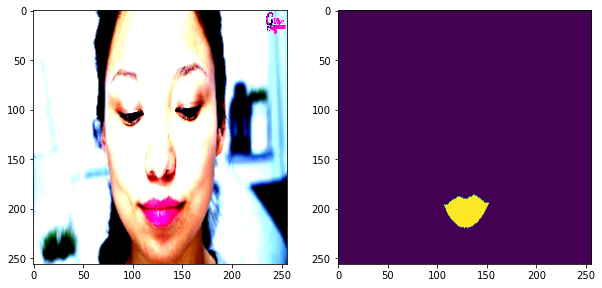

In [16]:
for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(images[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [17]:
criterion = smp.losses.BCELoss()
metrics = [smp.metrics.IoU(),]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [18]:
train_epoch = smp.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    verbose=True
)

valid_epoch = smp.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics=metrics,
    verbose=True
)

In [19]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './set-lipstick-original/model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████████████████████████| 1784/1784 [10:31<00:00,  2.82it/s, bce_loss - 0.0008714, iou_score - 0.929]
Model saved!


In [20]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
outputs = segmodel(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


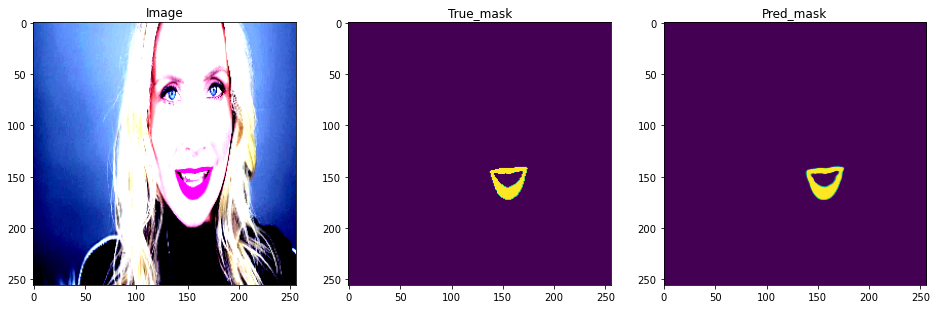

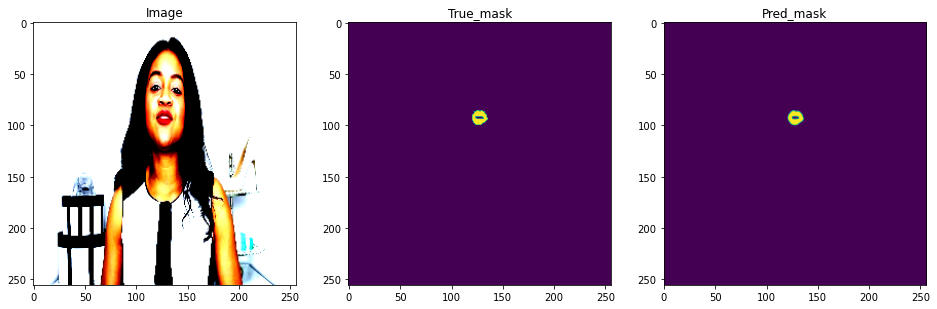

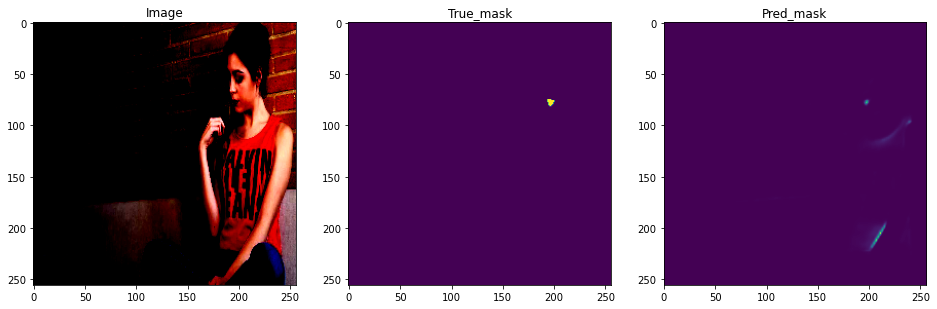

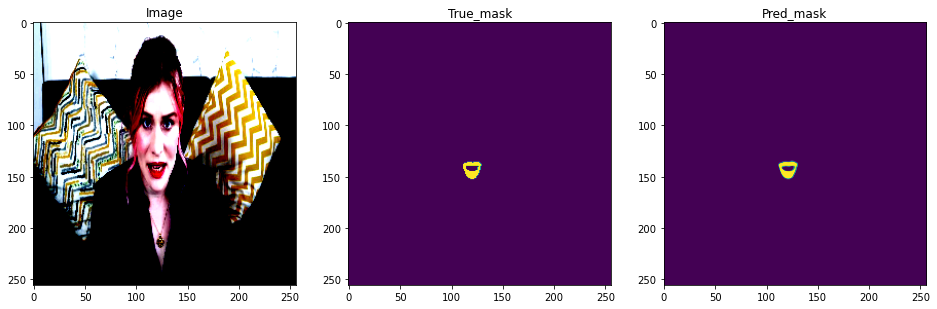

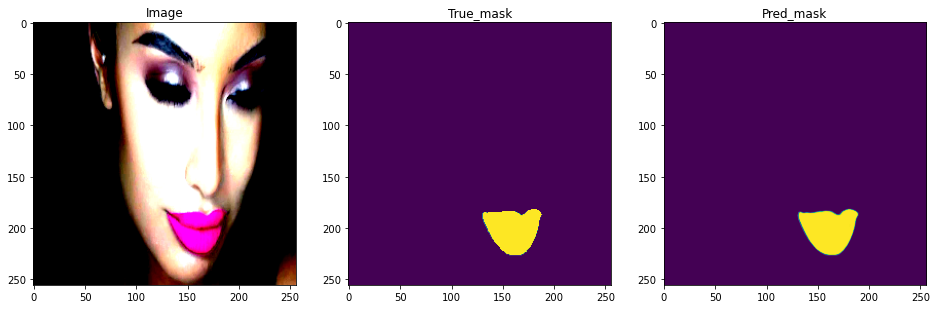

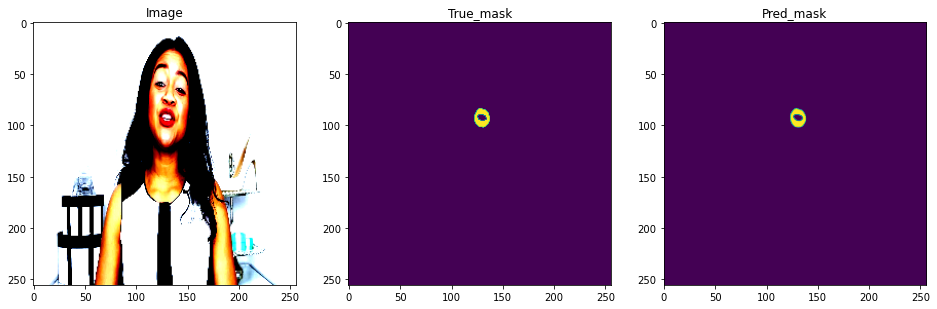

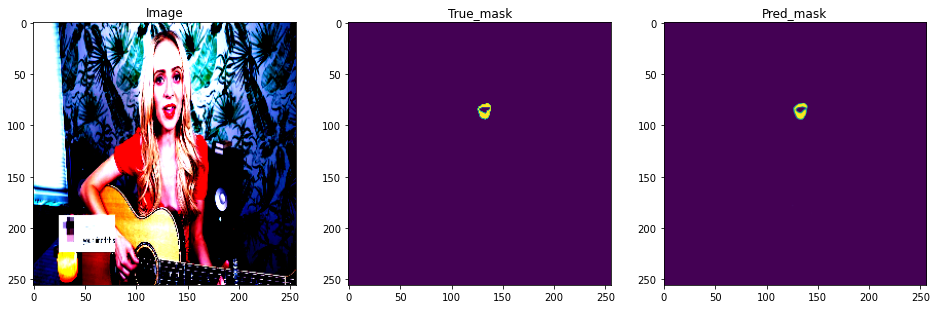

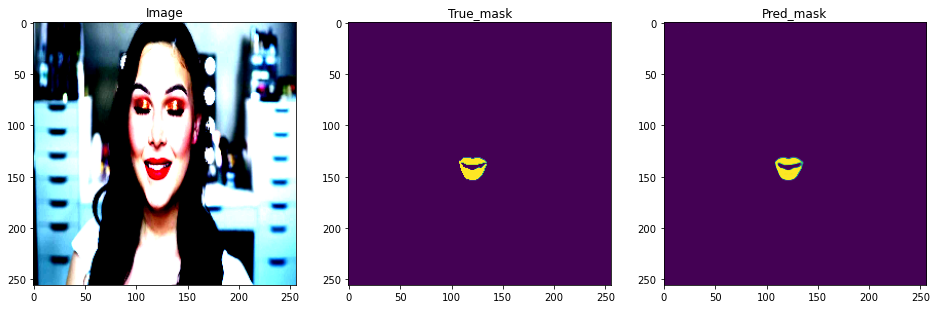

In [23]:
for i in range(images.shape[0]):
    fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16, 5))
    image = images[i].permute(1, 2, 0)
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')